<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/6_maximum_common_substructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Maximum common substructure

in this tutorial we will learn how to calculate the maximum common substructure that a set of compounds has in common.

it is the largest substructure that appears in two or more candidate molecules.

In [ ]:
pip install rdkit

In [ ]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

In [ ]:
sdf = str("molecule_set_largest_cluster.sdf")
supplier = Chem.ForwardSDMolSupplier(sdf)
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")
# NBVAL_CHECK_OUTPUT

Set with 146 molecules loaded.


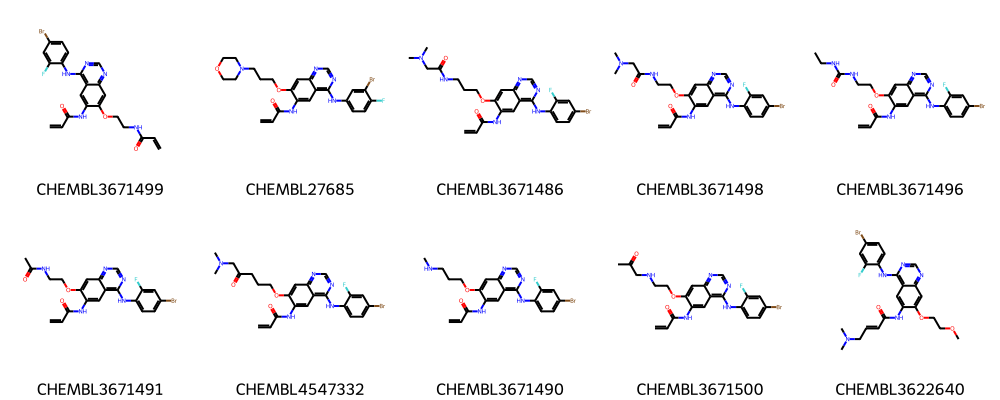

In [ ]:
# Show only first 10 molecules -- use slicing
num_mols = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)

In [ ]:
mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)
# NBVAL_CHECK_OUTPUT

MCS1 contains 24 atoms and 26 bonds.
MCS SMARTS string: [#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]


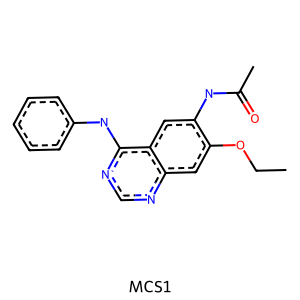

In [ ]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

In [ ]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

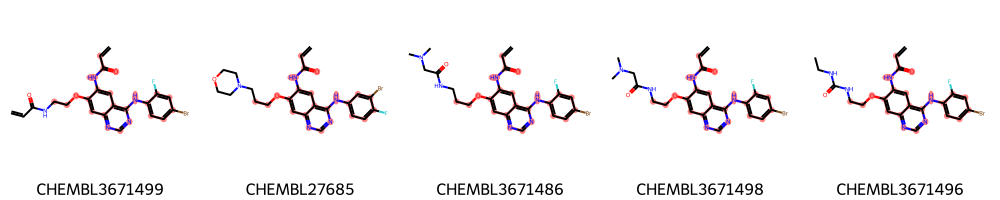

In [ ]:
highlight_molecules(mols, mcs1, 5)

In [ ]:
img = highlight_molecules(mols, mcs1, 3, useSVG=True)

# Get SVG data
molsvg = img.data

# Set background to transparent & Enlarge size of label
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open("mcs_largest_cluster.svg", "w") as f:
    f.write(molsvg)

In [ ]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)
# NBVAL_CHECK_OUTPUT

MCS2 contains 28 atoms and 30 bonds.
SMARTS string: [#6]=[#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3-[#9]):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]-[#7]-[#6]


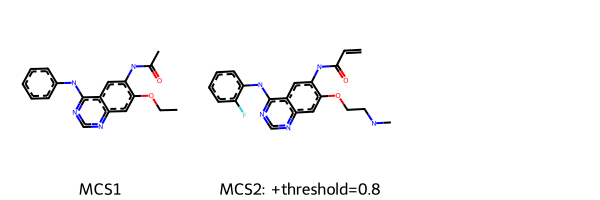

In [ ]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

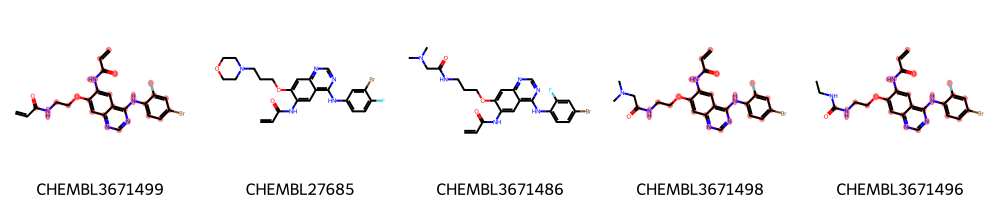

In [ ]:
highlight_molecules(mols, mcs2, 5)

In [ ]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

MCS3 contains 27 atoms and 29 bonds.
SMARTS string: [#6&!R]=&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]2:&@[#6&R](-&!@[#7&!R]-&!@[#6&R]3:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@3-&!@[#9&!R]):&@[#7&R]:&@[#6&R]:&@[#7&R]:&@[#6&R]:&@2:&@[#6&R]:&@[#6&R]:&@1-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#7&!R]


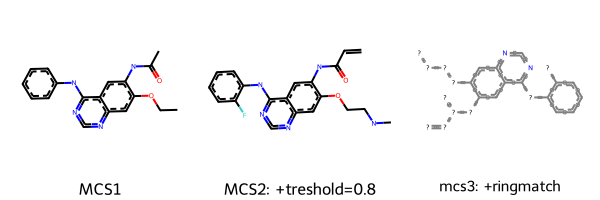

In [ ]:
# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

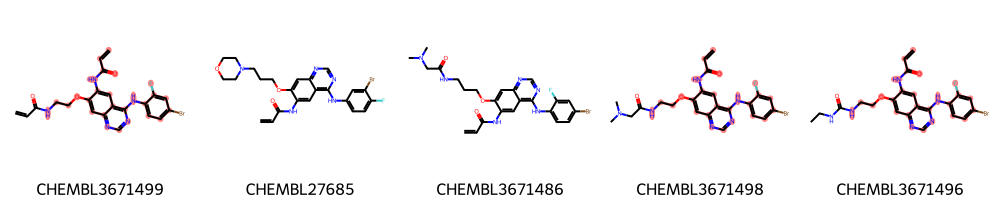

In [ ]:
highlight_molecules(mols, mcs3, 5)

In [ ]:
# Read full EGFR data
mol_df = pd.read_csv("EGFR_compounds.csv", index_col=0)
print("Total number of compounds:", mol_df.shape[0])

# Only keep molecules with pIC50 > 9 (IC50 > 1nM)
mol_df = mol_df[mol_df.pIC50 > 9]
print("Number of compounds with pIC50 > 9:", mol_df.shape[0])
# NBVAL_CHECK_OUTPUT

Total number of compounds: 6816
Number of compounds with pIC50 > 9: 322


In [ ]:
# Add molecule column to data frame
PandasTools.AddMoleculeColumnToFrame(mol_df, "smiles")
mol_df.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,<rdkit.Chem.rdchem.Mol object at 0x7dcb1314fed0>
1,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7dcb1314fe60>
2,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,<rdkit.Chem.rdchem.Mol object at 0x7dcb1314fdf0>


In [ ]:
mols_diverse = []
# Note: discarded variables we do not care about are usually referred to with a single underscore
for _, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name", row.molecule_chembl_id)
    mols_diverse.append(m)

In [ ]:
# We have fixed the random seed above (imports) for deterministic results
mols_diverse_sample = random.sample(mols_diverse, 50)

In [ ]:
threshold_diverse = 0.7
mcs1 = rdFMCS.FindMCS(mols_diverse_sample)
print("SMARTS string1:", mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(mols_diverse_sample, threshold=threshold_diverse)
print("SMARTS string2:", mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(mols_diverse_sample, ringMatchesRingOnly=True, threshold=threshold_diverse)
print("SMARTS string3:", mcs3.smartsString)
# NBVAL_CHECK_OUTPUT

SMARTS string1: [#6](:,-[#7]:,-[#6]):,-[#6]:,-[#6]-,:[#7]-,:[#6]:,-[#6]:,-[#6]:[#6]:,-[#6]:,-[#6]
SMARTS string2: [#6](:[#6]:,-[#6](:,-[#7]:,-[#6]:[#7]:[#6]-,:[#7]-,:[#6]:,-[#6]:,-[#6]:[#6]:,-[#6]:[#6]):,-[#6]):,-[#6]
SMARTS string3: [#6&R]:&@[#6&R]:&@[#7&R]:&@[#6&R]:&@[#7&R]:&@[#6&R]-&!@[#7&!R]-&!@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]


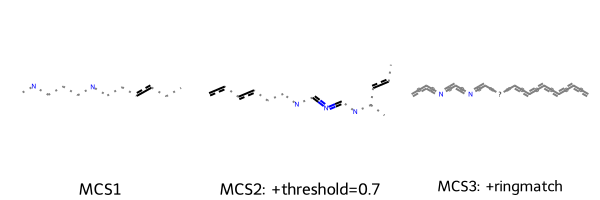

In [ ]:
# Draw substructures
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage(
    [m1, m2, m3],
    legends=[
        "MCS1",
        f"MCS2: +threshold={threshold_diverse}",
        "MCS3: +ringmatch",
    ],
)

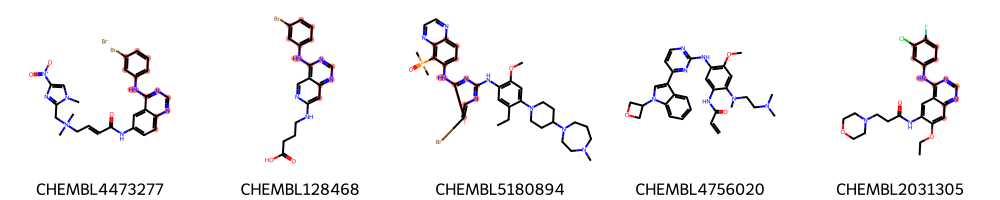

In [ ]:
highlight_molecules(mols_diverse_sample, mcs3, 5)

In [ ]:
def render_mcs(molecules, percentage):
    """Interactive widget helper. `molecules` must be wrapped in `ipywidgets.fixed()`,
    while `percentage` will be determined by an IntSlider widget."""
    tmcs = rdFMCS.FindMCS(molecules, threshold=percentage / 100.0)
    if tmcs is None:
        print("No MCS found")
        return None

    m = Chem.MolFromSmarts(tmcs.smartsString)
    print(tmcs.smartsString)
    return m

In [ ]:
# Note that the slider may take a few seconds to react
interact(
    render_mcs,
    molecules=fixed(mols_diverse_sample),
    percentage=widgets.IntSlider(min=0, max=100, step=10, value=70),
);

interactive(children=(IntSlider(value=70, description='percentage', step=10), Output()), _dom_classes=('widget…